<!--start-block-->
<hr style="height: 1px;">
<i>This code was authored by the 8.S50x Course Team, Copyright 2021 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

# LECTURE 15

It is often the case that you want to fit a function to data. However, sometimes you want to do this in many dimensions and you can't visualize it all. In this lecture, we are going to look at deep learning regression. This can help you to model these complex scenarios. 

Let's say you have some data $\vec{x}$, this can be an n-dimensional set of inputs, and you want to predict an output $\vec{y}$ from $\vec{x}$ where $y$ canbe m-dimensional set of outputs. What we want then is to create a function

\begin{equation}
 \vec{y} = f(\vec{x})
\end{equation}

Now in the past what we did was to do this for a one dimensional $y$ taking in a set of inputs $\vec{x}$. In this lecture, we aim to generalize this to predict an arbitrary number with an arbitrary set of inputs. 


<br>
<!--end-block-->
 - Fitting an arbitrary 1D dataset with a neural net
 - Deep Learning algorithm Design
 - Higgs to Tau leptons
 - Observing the improvements
 - Optimized Target
 - The full mass regression
 - NN Architecture
 
<!--start-block-->
<hr style="height: 1px;">

## 15.0 Overview of Learning Objectives

In this lecture we will explore the following objectives:


<br>

Before we do anything, lets make sure we install the tools we need for this. 
<!--end-block-->

In [1]:
!pip install torch
!pip install imageio

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio

## 15.1 Fitting an arbitrary 1D dataset with a neural net

What we would like to do is a fit a distribution without an initial choice fo a function. To envision this distribution, lets create a guassian function that is smeared out a little bit. From that, we can try to fit this dataset to get a functional form for this. 


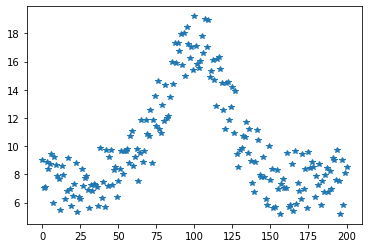

In [4]:
#Lets Try GP on a gaussian random set of points
def gaussian(mu,sigma,norm,offset):
    """Returns a gaussian function with the given parameters"""
    return lambda x: norm*np.exp(-(1./2.)*((x-mu)/(sigma))**2)+offset

Xin = np.mgrid[0:201] # points from 0 to 201
data = gaussian(100., 20., 10., 5)(Xin) + 5*np.random.random(Xin.shape) # Guassian + semaring
plt.plot(data,"*")

Now one way to model this distribution is through a Gaussian process. This will try to fit very many gaaussians that will allow us to extract a function. 

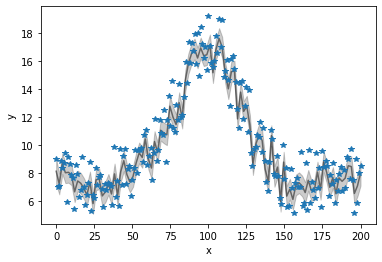

In [5]:
#now lets run GP on this guy
import george
from george import kernels
kernel = np.var(data) * kernels.ExpSquaredKernel(2.5)
gp = george.GP(kernel)
var=np.ones(len(Xin))
gp.compute(Xin,var)
x_pred = np.linspace(0, 200, 100)
pred, pred_var = gp.predict(data, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.plot(Xin,data,"*")
plt.xlabel("x")
plt.ylabel("y");

There are lots of flucations here. Clearly, the function is not ideal, and with a bit of tuning, we could probably approximate this. However, another way we can do this is with a neural network. 

In the past setup for classification, we defined a loss function as: 
\begin{equation}
\mathcal{L} = y \log(f(x)) + (1-y)\log(1-f(x))
\end{equation}
where here $f(x)$ is our classifier with 1 being a high likelihood of a signal, with value $0$, and $1$ for the classifier having a high likelihood of a background. Note the goal here is to minimize the loss, so we want to make sure that f(x) and 1-f(x) are orthongal.  

When we are running a deep learning algorithm, what we then are effectively doing is to to minimize the parameters: 
\begin{equation}
\frac{\partial \mathcal{L}}{\partial w_{i}}\rightarrow 0
\end{equation}

Now the power of deep learning is that we can fit any arbiratry function in the data. 

Let's start with a simplified dataset. 

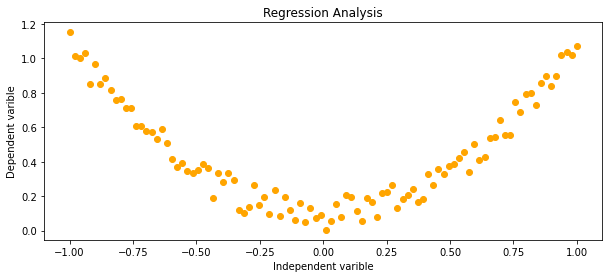

In [7]:
torch.manual_seed(1)    # reproducible

x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
y = x.pow(2) + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)

# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)

# view data
plt.figure(figsize=(10,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
plt.title('Regression Analysis')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.show()


Now fit this functtion, we can imagine definig a new loss that we can minimize to fit this function. In this case, we will define a loss known as mean squared error (MSE) loss. This loss can be written as 
\begin{equation}
\mathcal{L} = \left(y-f(x)\right)^{2}
\end{equation}
More generally, we can write this over $N$ variables as 

\begin{equation}
\mathcal{L} = \frac{1}{N}\sum_{i=1}^{N}\left(y_{i}-f(x_{i})\right)^{2}
\end{equation}

There are severval varations on this loss, perhaps the other most commone one is known as mean absolute percentage error (MAPE). This loss is defined as 

\begin{equation}
\mathcal{L} = \frac{100\%}{N}\sum_{i=1}^{N}\frac{|y_{i}-f(x_{i})|}{y_{i}}
\end{equation}

Let's fit a function with deep learning regression to do this, we are going train a two layered dense network to predict this function. 

Our one layered model can be written as 
\begin{equation}
 f(x) = W^{T}_{2}\left(\rm{Act}\left(\vec{W_{1}}x + \vec{b}\right)+b\right)
\end{equation}

Where $W_{1}$ and $W_{2}$ are matrices, well really vectors since the output dimension is 1 and the input dimension is 1. With these matrices, we can specify the number of hidden parameters, which will be the size of the alternative dimension. For 10 hidden parameters, $W_{i}$ will be a 10x1 matrix( 10 dimensional vector). $\rm{Act}$ here is the activation function for this system. 

Lets go ahead and build the neural network with 10 hidden parameters, mean squared loss. Additionally, for the minimizer, we will use stochastic graident descent (SGD). 

In [11]:
# this is one way to define a network
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

net = Net(n_feature=1, n_hidden=20, n_output=1)     # define the network
print(net)  # net architecture
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)#stochastic Gradient Descent
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

Net(
  (hidden): Linear(in_features=1, out_features=20, bias=True)
  (predict): Linear(in_features=20, out_features=1, bias=True)
)


Ok, now that we have our neural network, what we are going to do is run 200 epochs of the network training, and for each epcoh, we are going to make a plot. Then we will turn this plot into a moving video to see how the network is running. 

epoch: 0
epoch: 50
epoch: 100
epoch: 150


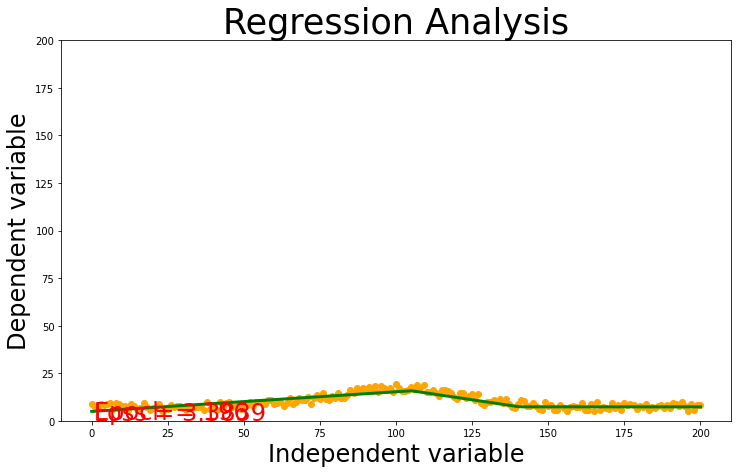

In [26]:
def makePlot(x,y,prediction,ax,fig,images,t,loss):
    # plot and show learning process
    plt.cla()
    ax.set_title('Regression Analysis', fontsize=35)
    ax.set_xlabel('Independent variable', fontsize=24)
    ax.set_ylabel('Dependent variable', fontsize=24)
    ax.set_ylim(0,20)
    ax.set_ylim(0,200)
    ax.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
    ax.plot(x.data.numpy(), prediction.data.numpy(), 'g-', lw=3)
    ax.text(0.6, 0.7, 'Epoch = %d' % t, fontdict={'size': 24, 'color':  'red'})
    ax.text(0.6, 0.3, 'Loss = %.4f' % loss.data.numpy(),fontdict={'size': 24, 'color':  'red'}) 
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)

def train(x,y,net,loss_func,opt,nepochs):
    images = []
    fig, ax = plt.subplots(figsize=(12,7))
    for epoch in range(nepochs):
        if epoch % 50 == 0: 
            print("epoch:",epoch)
        prediction = net(x)
        loss = loss_func(prediction, y) 
        opt.zero_grad()
        loss.backward() 
        optimizer.step()
        if epoch % 4 == 0:
            makePlot(x,y,prediction,ax,fig,images,epoch,loss)
    return images
    

images=train(x,y,net,loss_func,optimizer,200)
imageio.mimsave('./curve_1.gif', images, fps=10)

Ok, this is actually a great way to play around with models. For a quick look at how things change, lets double the number of hidden parameters. 

Ok, now lets look at another function to regress, lets try to regress 

\begin{equation}
 f(x) = \sin(x)
\end{equation}

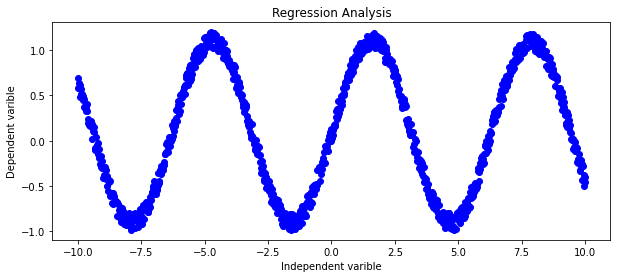

In [13]:
torch.manual_seed(1)    # reproducible
x = torch.unsqueeze(torch.linspace(-10, 10, 1000), dim=1)  # x data (tensor), shape=(100, 1)
y = torch.sin(x) + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)

# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)
plt.figure(figsize=(10,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color = "blue")
plt.title('Regression Analysis')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.show()

## Challenge question :

Make a regression for the above dataset? How does this regression change with the number of paramters, say 100 hidden parameters?

epoch: 0
epoch: 50
epoch: 100
epoch: 150


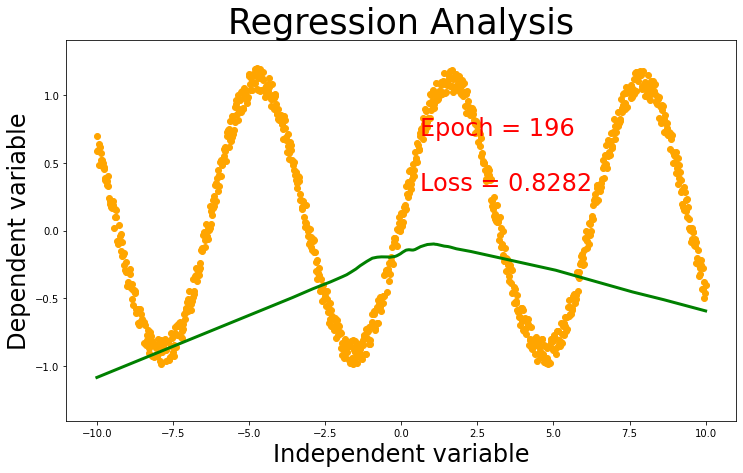

In [17]:
net = Net(n_feature=1, n_hidden=100, n_output=1)     # define the network
images=train(x,y,net,loss_func,optimizer,200)
imageio.mimsave('./curve_2.gif', images, fps=10)

epoch: 0
epoch: 50
epoch: 100
epoch: 150


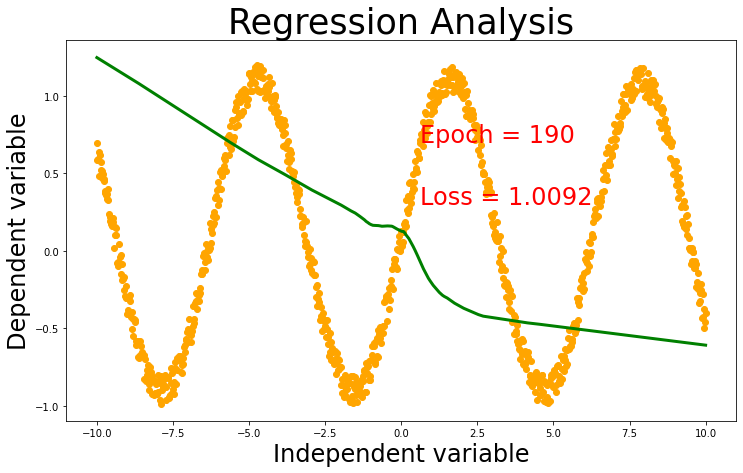

In [11]:
#redefine network
net = Net(n_feature=1, n_hidden=100, n_output=1)     # define the network
images=train(x,y,net,loss_func,optimizer,200)
imageio.mimsave('./curve_2.gif', images, fps=10)

## 15.2 Deep Learning algorithm Design

Now to build some intutition of how neutral networks work. Let's take the above problem and see if we can really explin its behavior doing some deep learning R&D. To do that, lets first take an architecture similar to the last one, except with more than 2 layers. 

Let's start with a 3 layer network with 100 hidden parameters, and then 50 hidden parameters in the second layer.  

tensor([[ 0.5974],
        [-0.0480],
        [ 0.7242],
        [ 0.8789],
        [-0.0524],
        [ 0.8037],
        [ 0.7254],
        [ 0.1578],
        [-0.4336],
        [-0.3352]], grad_fn=<SliceBackward>)
epoch: 0
epoch: 50
epoch: 100
epoch: 150


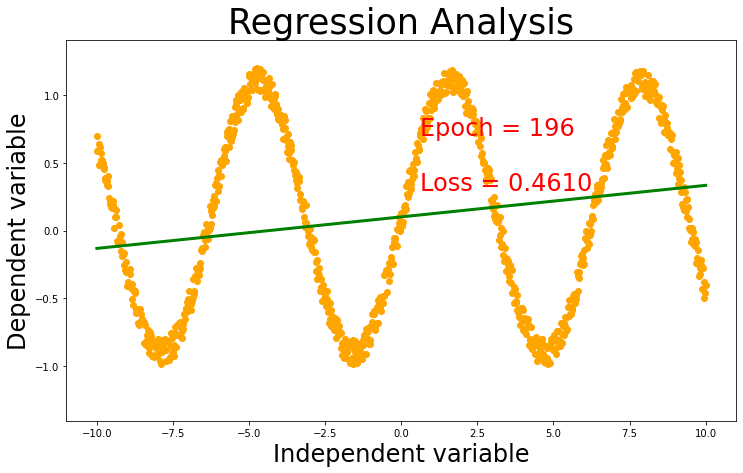

In [19]:
# another way to define a network
net = torch.nn.Sequential(
        torch.nn.Linear(1, 100),
        torch.nn.Linear(100, 50),
        torch.nn.Linear(50, 1),
    )
print(net[0].weight[0:10])
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()
images=train(x,y,net,loss_func,optimizer,200)
imageio.mimsave('./curve_2.gif', images, fps=10)

Why did it just fit a line to this? 

The answer is a bit sublte, but the network is lacking "expressiveness" to solve this problem. A linear layer is just a matrix multiplication, what that means is that we can just multiply by our initial input by a constant and add an offset $ax+b$ with each layer. Now its true that $a$ can be a matrix. However that is just giving a vector of linear outputs. To fix this, lets add in an "activation" layer between them. 

epoch: 0
epoch: 50
epoch: 100
epoch: 150


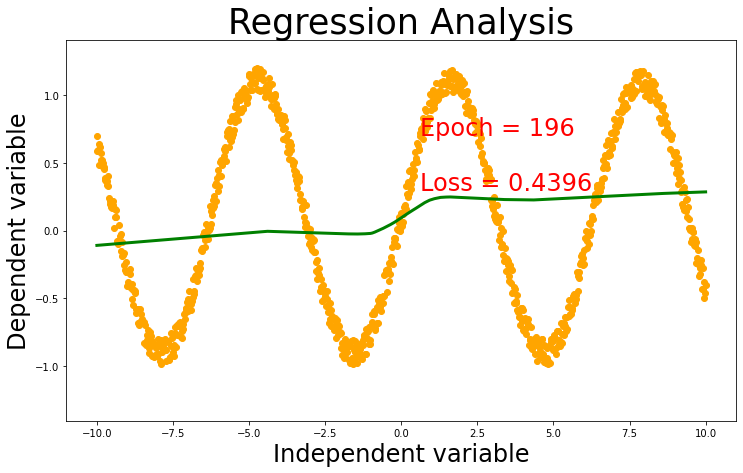

In [20]:
# another way to define a network
net = torch.nn.Sequential(
        torch.nn.Linear(1, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 50),
        torch.nn.Linear(50, 1),
    )
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()
images=train(x,y,net,loss_func,optimizer,200)
imageio.mimsave('./curve_2.gif', images, fps=10)

And finally, lets put a few activation layers

epoch: 0
epoch: 50
epoch: 100
epoch: 150
epoch: 200
epoch: 250
epoch: 300
epoch: 350


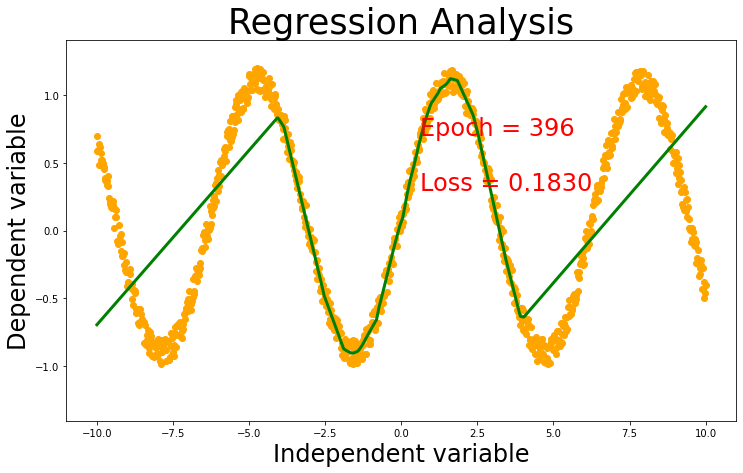

In [22]:
# another way to define a network
net = torch.nn.Sequential(
        torch.nn.Linear(1, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 50),
        torch.nn.ReLU(),
        torch.nn.Linear(50, 1),
    )
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()
images=train(x,y,net,loss_func,optimizer,400)
imageio.mimsave('./curve_2.gif', images, fps=10)

### Challenge Question

Given the observed trends, add more layers to your network. How many layers are needed to describe the whole oscillation? 


epoch: 0
epoch: 50
epoch: 100
epoch: 150
epoch: 200
epoch: 250
epoch: 300
epoch: 350


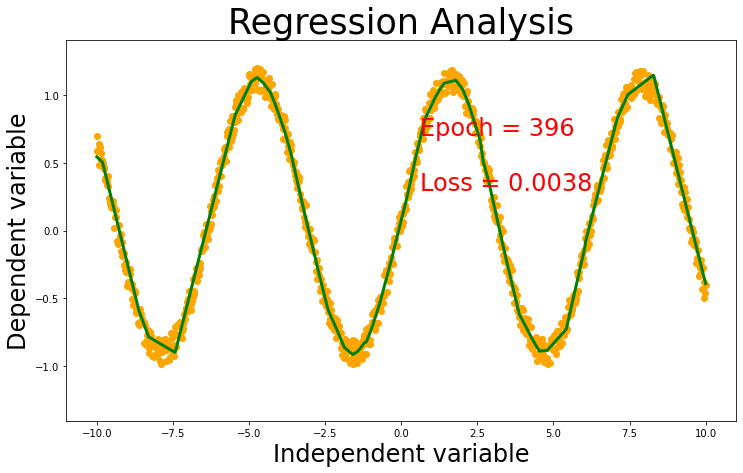

In [23]:
net = torch.nn.Sequential(
        torch.nn.Linear(1, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 50),
        torch.nn.ReLU(),
        torch.nn.Linear(50, 50),
        torch.nn.ReLU(),
        torch.nn.Linear(50, 1),
    )
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()
images=train(x,y,net,loss_func,optimizer,400)
imageio.mimsave('./curve_2.gif', images, fps=10)

epoch: 0
epoch: 50
epoch: 100
epoch: 150
epoch: 200
epoch: 250
epoch: 300
epoch: 350
epoch: 400
epoch: 450
epoch: 500
epoch: 550
epoch: 600
epoch: 650
epoch: 700
epoch: 750
epoch: 800
epoch: 850
epoch: 900
epoch: 950


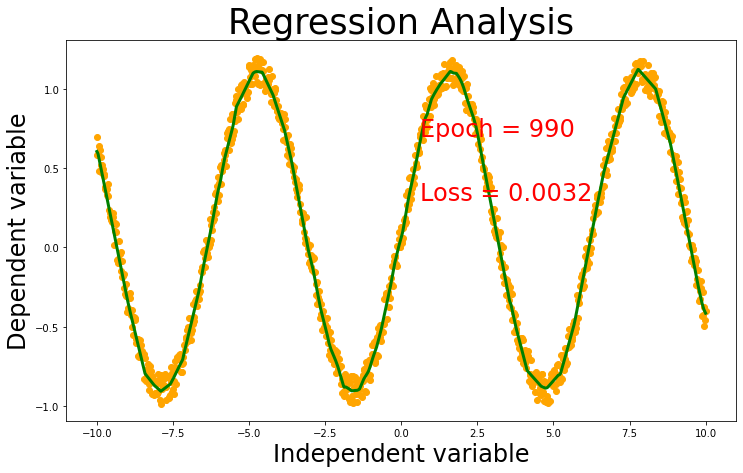

In [33]:
# answer
net = torch.nn.Sequential(
        torch.nn.Linear(1, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 50),
        torch.nn.ReLU(),
        torch.nn.Linear(50, 1),
    )
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
images=train(x,y,net,loss_func,optimizer,1000)
imageio.mimsave('./curve_2_c.gif', images, fps=10)

Now that we have all of this working, what would be the right architecture to perform a Gaussian regression? 

Lets setup the data using the torch tools.

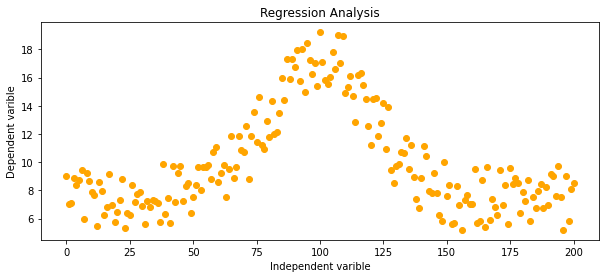

In [24]:
torch.manual_seed(1)    # reproducible

x=torch.unsqueeze(torch.linspace(0, 200, 201), dim=1) 
y=torch.from_numpy(data.reshape(len(data),1).astype('float32'))

# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)

# view data
plt.figure(figsize=(10,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
plt.title('Regression Analysis')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.show()


Since we have a gaussian, there are 3 inflection points, a 4 layer network with not so many parameters should do the trick. Lets try!

epoch: 0
epoch: 50
epoch: 100
epoch: 150
epoch: 200
epoch: 250


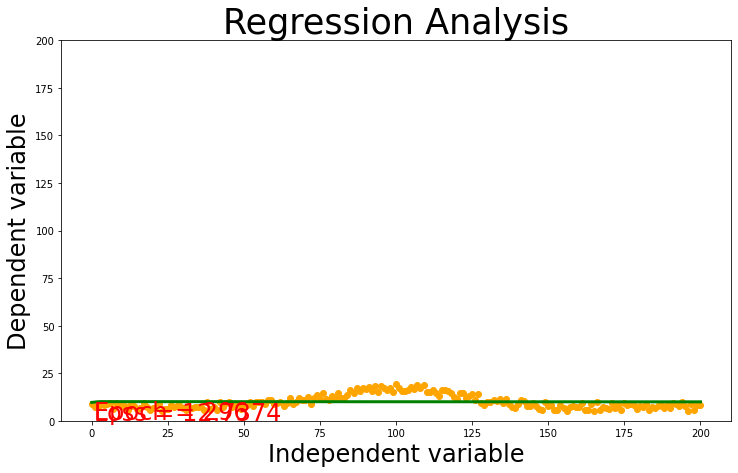

In [27]:
# answer
net = torch.nn.Sequential(
        torch.nn.Linear(1, 10),
        torch.nn.ReLU(),
        torch.nn.Linear(10, 10),
        torch.nn.ReLU(),
        torch.nn.Linear(10, 10),
        torch.nn.ReLU(),
        torch.nn.Linear(10, 1),
    )
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
images=train(x,y,net,loss_func,optimizer,300)
imageio.mimsave('./curve_gaus.gif', images, fps=10)

epoch: 0
epoch: 50
epoch: 100
epoch: 150
epoch: 200
epoch: 250
epoch: 300
epoch: 350
epoch: 400
epoch: 450
epoch: 500
epoch: 550
epoch: 600
epoch: 650
epoch: 700
epoch: 750
epoch: 800
epoch: 850
epoch: 900
epoch: 950


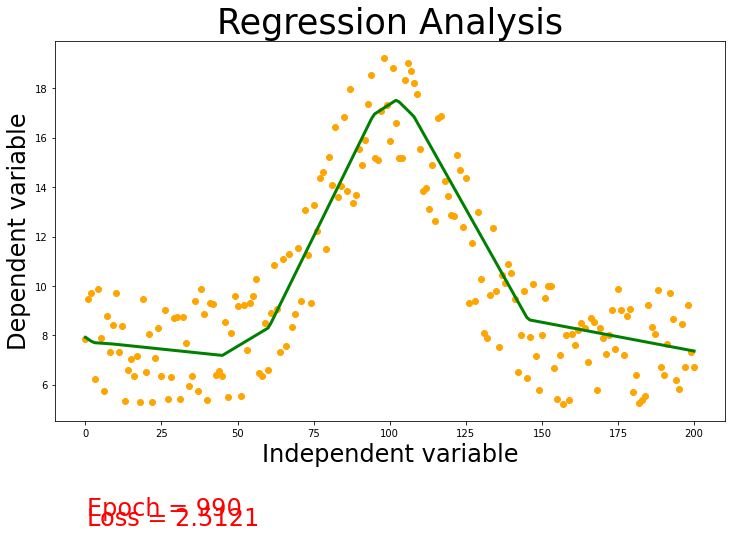

In [46]:
n_hidden=10
net = torch.nn.Sequential(
        torch.nn.Linear(1, n_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(n_hidden, n_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(n_hidden, n_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(n_hidden, 1),
    )
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
images=train(x,y,net,loss_func,optimizer,1000)
imageio.mimsave('./curve_gaus.gif', images, fps=10)

## 15.3 Higgs to Tau leptons

In the following section, we are going to use deep learning regression to solve an important problem in Higgs identification and reconstruction. In particular, what we are going to study is the Higgs boson decay to $\tau$ leptons. 

The Higgs boson decays to many different objects. The most likely object that the Higgs boson decays to are b-quarks. The 4th most likely components that the Higgs boson decays to are the $\tau$ leptons. Tau leptons are effectively Heavy electrons, or muons, and behave in similar ways to the electrons and muons.  

We will look at the Higgs boson produced at the LHC. The Higgs boson can only be produced at the LHC, and then we can measure its properties by looking at the decay products at the collider. 

The important aspect of $\tau$ leptons that we will focus on in this lecture is that a $\tau$ can decay to neutrinos, and either an electron and a neutrino, a muon and a neutrino, or quarks. Electrons, muons and quarks can be reconstructed in a collider detector. However, the neutrinos cannot. Neutrinos are very weakly interacting and they will just escape the detector. 

The one constraint we have for neutrinos is what we call missing transverse energy. Missing transverse energy is a constraint that originates from the fact that when we collider protons along a specific axis, the momentum transverse to that axis is conserved, or in other words. 

\begin{equation}
\sum_{i=1}^{N}\vec{p_{T,i}} = 0 \\
\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} + \sum_{i= {\rm neutrino}}^{N}\vec{p_{T,i}} = 0 \\
\sum_{i= {\rm neutrino}}^{N}\vec{p_{T,i}} = -\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} \\
\rm{\vec{MET}}  = -\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} \\
\end{equation}

This is what we call the MET or missing transverse energy. This is our only constraint on the neutrinos and it gives us a vector in the plane perpendicular to the collision axis along the beam.  

As was the case with the W and Z boson project, the best way to find the Higgs decaying to $\tau$ leptons is to reconstruct the mass and look for a bump. The challenge then of finding this process, is to, first, identify the $\tau$ leptons, and, second, reconstruct the mass of the Higgs boson decays. 

When we have a Higgs decay to $\tau$ it decays to 2 tau leptons, which means that we will get anywhere from $2-4$ neutrinos. What we want to do in our machine learning algorithm is to identify the topology, and return back a 4-vector that is the sum of all the neutrinos together.  

Ok, lets now load a dataset that we can use to run this problem. 

In [28]:
import uproot
from collections import OrderedDict 
reg    = uproot.open("Regression2.root")["Tree"]

In [29]:
#what are the inputs
print(reg.keys())
cut=reg['genpt1'].array() >  100
vals=reg['genpt1'].array(library="np")[cut]
np.histogram(vals)

['genpt1', 'geneta1', 'genphi1', 'genpt2', 'geneta2', 'genphi2', 'hpt', 'heta', 'hphi', 'hmass', 'part1pt1', 'part1eta1', 'part1phi1', 'part1id1', 'part1pt2', 'part1eta2', 'part1phi2', 'part1id2', 'part1pt3', 'part1eta3', 'part1phi3', 'part1id3', 'part1pt4', 'part1eta4', 'part1phi4', 'part1id4', 'part1pt5', 'part1eta5', 'part1phi5', 'part1id5', 'recopt1', 'recoeta1', 'recophi1', 'recomass1', 'part2pt1', 'part2eta1', 'part2phi1', 'part2id1', 'part2pt2', 'part2eta2', 'part2phi2', 'part2id2', 'part2pt3', 'part2eta3', 'part2phi3', 'part2id3', 'part2pt4', 'part2eta4', 'part2phi4', 'part2id4', 'part2pt5', 'part2eta5', 'part2phi5', 'part2id5', 'recopt2', 'recoeta2', 'recophi2', 'recomass2', 'recohpt', 'recoheta', 'recohphi', 'recohmass']


(array([2834,  648,  194,   84,   32,   17,    5,    2,    2,    2]),
 array([100.0013 , 149.9324 , 199.86353, 249.79465, 299.72577, 349.65686,
        399.58798, 449.5191 , 499.4502 , 549.38135, 599.31244],
       dtype=float32))

This is a bit of a complicated dataset. Let's go through and explain....


Ok, lets plot the reconstructed transverse momentum of one of the $\tau$ and the generator transverse momentum of the true tau lepton. 

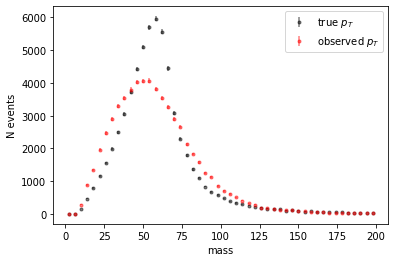

In [30]:
import numpy as np

def plot(iVar,iMin,iMax,iColor,iLabel): 
    mask=(reg[iVar].array() > 0)
    data=reg[iVar].array(library="np")[mask]
    counts, binEdges = np.histogram(data,bins=50,range=(iMin,iMax),density=False)
    binCenters = (binEdges[1:]+binEdges[:-1])*.5
    err = np.sqrt(counts)
    plt.errorbar(binCenters, counts, yerr=err,fmt="o",alpha=0.5,c=iColor,label=iLabel, ms=3)
    plt.xlabel("mass")
    plt.ylabel("N events")
    return binCenters,counts,err
plot("genpt1",0,200,"black","true $p_{T}$")
plot("recopt1",0,200,"red","observed $p_{T}$")
plt.legend()
plt.show()

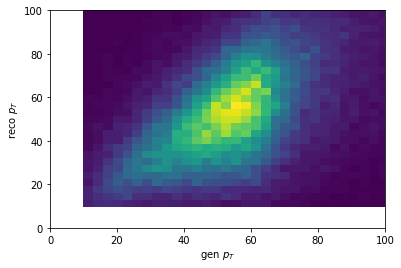

In [31]:
#To visualize the whole problem lets make a 2D plot
mask=np.logical_and(reg["genpt1"].array() > 0, reg["recopt1"].array()>0)
x=reg["genpt1"].array(library="np")[mask]
y=reg["recopt1"].array(library="np")[mask]
plt.xlabel("gen $p_{T}$")
plt.ylabel("reco $p_{T}$")
plt.hist2d(x,y,bins=200)
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()

So what we see is that reconstructed momentum is not directly correlated with the generator momentum. This is different to the cases in the last section, and what it means is that we will eventually need more variables to actual get the true momentum of the $\tau$ system. 

With all this information, lets go ahead and build a regression. We can start form our previous setup, and try to just take in the the reconstructed momentum, and predict the true momentum. 

In [32]:
#Let's prepare teh data to be pytorch friendly
x=torch.from_numpy(reg["recopt1"].array(library="np")[mask].reshape(len(reg["recopt1"].array(library="np")[mask]),1))
y=torch.from_numpy(reg["genpt1"].array(library="np")[mask].reshape(len(reg["genpt1"].array(library="np")[mask]),1))
x, y = Variable(x), Variable(y)
#torch_dataset = Data.TensorDataset(x, y)
#loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,)

#Now lets make a simple model
net = torch.nn.Sequential(
        torch.nn.Linear(1, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 1),
    )
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

In [33]:
def makePlot(x,y,prediction,ax,fig,images,t,loss):
    # plot and show learning process
    plt.cla()
    ax.set_title('Regression Analysis', fontsize=35)
    ax.set_xlabel('Independent variable', fontsize=24)
    ax.set_ylabel('Dependent variable', fontsize=24)
    ax.hist(prediction.data.numpy(),color="red",bins=20,range=(0,200),alpha=0.5,label='pred')
    ax.hist(y.data.numpy(),color="black" ,bins=20,range=(0,200),alpha=0.5,label='gen')
    ax.hist(x.data.numpy(),color="green",bins=20,range=(0,200),alpha=0.5,label='reco')
    ax.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
    ax.plot(x.data.numpy(), prediction.data.numpy(), 'g-', lw=3)
    ax.text(100, 2000, 'Epoch = %d' % t,fontdict={'size': 24, 'color':  'red'})
    ax.text(100, 5000, 'Loss = %.4f' % loss.data.numpy(),fontdict={'size': 24, 'color':  'red'})
    fig.canvas.draw()       # draw the canvas, cache the renderer
    ax.legend()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)

epoch: 0
epoch: 50


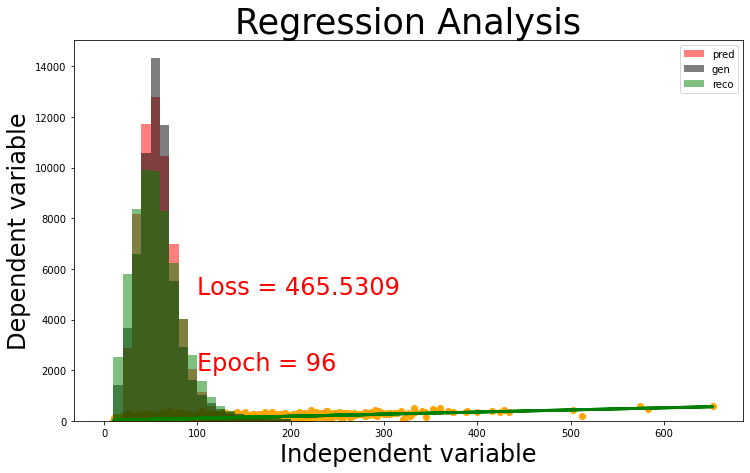

In [34]:
images=train(x,y,net,loss_func,optimizer,100)
imageio.mimsave('./reg1.gif', images, fps=12)

So we can see, it tries to predict the average, but its not that great. Lets look at hte properties of this. 

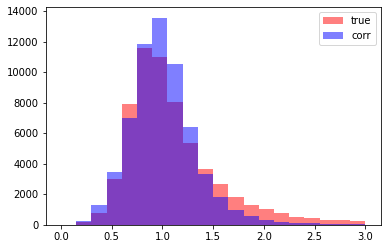

True Mean:  1.1537236 True StdDev: 0.6145453
NN Mean:  1.0125828 NN StdDev: 0.347898


In [85]:
#What did this do?
true=reg["genpt1"].array(library="np")[mask]
reco=reg["recopt1"].array(library="np")[mask]
pred=net(x)
ratio=np.array(true/reco)
ratiopred=y/pred
plt.hist(ratio,color="red",bins=20,range=(0,3),alpha=0.5,label="true")
plt.hist(ratiopred.data.numpy(),color="blue",bins=20,range=(0,3),alpha=0.5,label="corr")
plt.legend()
plt.show()
print("True Mean: ",ratio.mean(),"True StdDev:",ratio.std())
print("NN Mean: ",ratiopred.data.numpy().mean(),"NN StdDev:",ratiopred.data.numpy().std())

## 15.4 Observing the improvements

Ok, so we now have a very basic regressoin that predict a single neutrino from a single $\tau$ lepton decay. This is a very simple regression, and we see that the prediction doesn't work so well. Also, its a bit hard to understand exactly what the training is doing. 

In light of this, lets write some code from these samples to actually reconstruct the Higgs boson mass, then we can go back to the training and see if we can really optimize it. 

If we look at the dataset, we find that we have two variables that give the mass. One is the "True Higgs boson mass", this is the Higgs boson mass that is created by our monte carlo simulation. For each event, we sample a Higgs boson mass distribution, this is our sampled event. 

For the second mass, what this is doing is take the reconstructed $\tau$ object, without the neutrinos and compute the mass by adding the 4-vectors. In other words, the mass can be written as a sum of the reconstructed 4-vectors of the two identified and reconstructed $\tau$ leptons. In other words, 
\begin{equation}
m_{\rm vis} = \left(E_{1} + E_{2} \right)^2 - \left(\vec{p}_{1} + \vec{p}_{2}\right)^2
\end{equation}

We call this the visible mass, for the simple fact that it excludes all the invisible particles (aka neutrinos). We will forgo the details of how the 4-vectors are reconstructed. However, just assume its a complciated process. Ok, let's plot the mass 

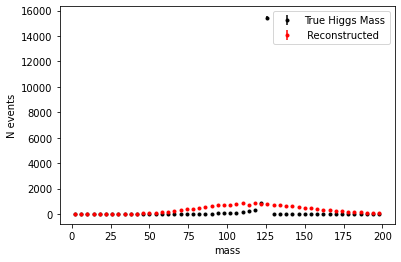

In [87]:
#now lets construct the higgs mass
plot("hmass",0,200,"black","True Higgs Mass")
plot("recohmass",0,200,"red"," Reconstructed")
plt.legend()
plt.show()

Now, to build a correction to the $\tau$ lepton momentum, what we can do is is reconstruct the 4-vectors. To do this we are going to use the pylorentz vector, wich just does the calculation above. 

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


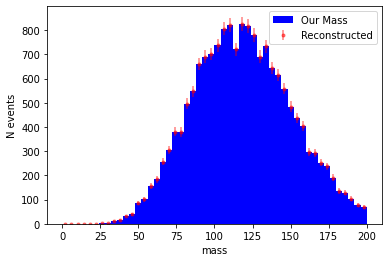

In [35]:
!pip install pylorentz
from pylorentz import Momentum4

#Lets compute the mass on the fly
def masscompute(iVec1,iVec2):
    tau_1 = Momentum4.m_eta_phi_pt(iVec1[3], iVec1[1], iVec1[2], iVec1[0])
    tau_2 = Momentum4.m_eta_phi_pt(iVec2[3], iVec2[1], iVec2[2], iVec2[0])
    return (tau_1+tau_2).m
    
def hmass(massfunc):
    mask=(reg["recohmass"].array() > 0)
    varlist=["recopt1","recoeta1","recophi1","recomass1","recopt2","recoeta2","recophi2","recomass2"]
    arr=0
    idx=0
    for x in varlist:
        pArr=reg[x].array(library="np")[mask]
        if idx == 0: 
            arr = pArr
            idx = idx + 1
        else:
            arr=np.vstack((arr,pArr))
    arr = arr.T
    massc = lambda iarr: massfunc(iarr[0:4],iarr[4:8]) 
    hmasses = np.array([massc(p) for p in arr])
    return hmasses

rawmvis=hmass(masscompute)
plt.hist(rawmvis,bins=50,range=(0,200),color='blue',label="Our Mass")
#plot("hmass",0,200,"black","True Higgs Mass")
plot("recohmass",0,200,"red","Reconstructed")
plt.legend()
plt.show()

Ok, great, looks like we can reconstruct the mass. Lets take a look at our how our regression mass looks like. To do this, what we will do is modify our mass computation to include the neural net clalculation.

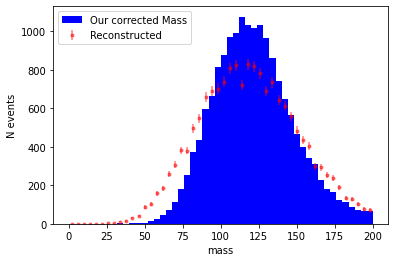

In [36]:
#Lets compute the mass on the fly
def masscompute(iVec1,iVec2):
    pt1 = torch.tensor([iVec1[0]])
    pt2 = torch.tensor([iVec2[0]])
    corr1 = net(pt1).data.numpy()
    corr2 = net(pt2).data.numpy()
    tau_1 = Momentum4.m_eta_phi_pt(iVec1[3], iVec1[1], iVec1[2], corr1)
    tau_2 = Momentum4.m_eta_phi_pt(iVec2[3], iVec2[1], iVec2[2], corr2)
    return (tau_1+tau_2).m

rawmass=hmass(masscompute)
plt.hist(rawmass,bins=50,range=(0,200),color='blue',label="Our corrected Mass")
#plot("hmass",0,200,"black","True Higgs Mass")
plot("recohmass",0,200,"red","Reconstructed")
plt.legend()
plt.show()

So this is making the mass narrower. However, as we know, this network is not necessarily respecting the mass. To see this, lets just make a toy dataset by sampling a distribution. 

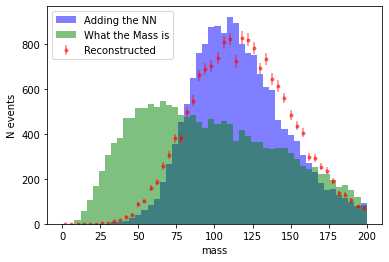

In [160]:
#Lets compute the mass on the fly
def masscompute(iVec1,iVec2):
    pVal=torch.distributions.Uniform(0, 100).sample((2,1))
    corr = net(pVal).data.numpy()
    tau_1 = Momentum4.m_eta_phi_pt(iVec1[3], iVec1[1], iVec1[2], corr[0])
    tau_2 = Momentum4.m_eta_phi_pt(iVec2[3], iVec2[1], iVec2[2], corr[1])
    return (tau_1+tau_2).m

def masscomputeNoNN(iVec1,iVec2):
    pVal=torch.distributions.Uniform(0, 100).sample((2,1))
    tau_1 = Momentum4.m_eta_phi_pt(iVec1[3], iVec1[1], iVec1[2], pVal[0])
    tau_2 = Momentum4.m_eta_phi_pt(iVec2[3], iVec2[1], iVec2[2], pVal[1])
    return (tau_1+tau_2).m

rawmass=hmass(masscompute)
plt.hist(rawmass,bins=50,range=(0,200),color='blue',alpha=0.5,label="Adding the NN")

rawmass=hmass(masscomputeNoNN)
plt.hist(rawmass,bins=50,range=(0,200),color='green',alpha=0.5,label="What the Mass is")

#plot("hmass",0,200,"black","True Higgs Mass")
recohmassX,recohmassY,recohmassYErr=plot("recohmass",0,200,"red","Reconstructed")
plt.legend()
plt.show()

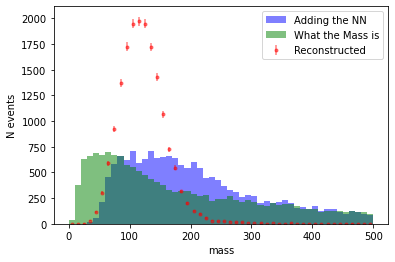

In [157]:
#Lets compute the mass on the fly
def masscompute(iVec1,iVec2):
    pVal=torch.distributions.Uniform(0, 20).sample((2,1))
    pVal=pVal**2
    corr = net(pVal).data.numpy()
    tau_1 = Momentum4.m_eta_phi_pt(iVec1[3], iVec1[1], iVec1[2], corr[0])
    tau_2 = Momentum4.m_eta_phi_pt(iVec2[3], iVec2[1], iVec2[2], corr[1])
    return (tau_1+tau_2).m

def masscomputeNoNN(iVec1,iVec2):
    pVal=torch.distributions.Uniform(0, 20).sample((2,1))
    pVal=pVal**2
    tau_1 = Momentum4.m_eta_phi_pt(iVec1[3], iVec1[1], iVec1[2], pVal[0])
    tau_2 = Momentum4.m_eta_phi_pt(iVec2[3], iVec2[1], iVec2[2], pVal[1])
    return (tau_1+tau_2).m

rawmass=hmass(masscompute)
plt.hist(rawmass,bins=50,range=(0,500),color='blue',alpha=0.5,label="Adding the NN")

rawmass=hmass(masscomputeNoNN)
plt.hist(rawmass,bins=50,range=(0,500),color='green',alpha=0.5,label="What the Mass is")

#plot("hmass",0,200,"black","True Higgs Mass")
plot("recohmass",0,500,"red","Reconstructed")
plt.legend()
plt.show()

## 15.5 Optimized Target

Now before we go ahead and try to make the most sophisticated deep learning regression. Lets go ahead and expore an optimzied target. 

In our first training we trained for $p_{T}^{Gen}$ of the neutrino. However, we could imagine instead of training for a dimensionless variable of : 
\begin{equation}
\frac{p_{T}^{Gen}}{p_{T}^{Reco}}
\end{equation}
instead. The advantage of this target is that it is unitless, which means that if there is an invrance against momentum, like lorentz invariance, we can capture it in this quantity. Defining losses, which respect invariant quantities in physics has become an industry over the past few years. Lets go ahead and repeat our training from before. Also, lets update our training performance code to reconstruct the mass. 

In [42]:
#Now lets make a simple model
net = torch.nn.Sequential(
        torch.nn.Linear(1, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 1),
    )
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()
x=torch.from_numpy(reg["recopt1"].array(library="np")[mask].reshape(len(reg["recopt1"].array(library="np")[mask]),1))
y=torch.from_numpy(reg["genpt1"].array(library="np")[mask].reshape(len(reg["genpt1"].array(library="np")[mask]),1))
x, y = Variable(x), Variable(y)
ratio=torch.div(y,x)
y=ratio

#Lets compute the mass on the fly
def masscomputeNN(iVec1,iVec2):
    pt1 = torch.tensor([iVec1[0]])
    pt2 = torch.tensor([iVec2[0]])
    corr1 = net(pt1).data.numpy()*iVec1[0]
    corr2 = net(pt2).data.numpy()*iVec2[0]
    tau_1 = Momentum4.m_eta_phi_pt(iVec1[3], iVec1[1], iVec1[2], corr1)
    tau_2 = Momentum4.m_eta_phi_pt(iVec2[3], iVec2[1], iVec2[2], corr2)
    return (tau_1+tau_2).m

#And lets plot the mass instead of the pT
def makePlot(x,y,prediction,ax,fig,images,t,loss):
    #compute the mass
    rawmass=hmass(masscomputeNN)
    # plot and show learning process
    plt.cla()
    ax.hist(rawmvis,bins=40,range=(0,250),color='blue',alpha=0.5,label='raw')
    ax.hist(rawmass,bins=40,range=(0,250),color='red',alpha=0.5,label='regressed')
    ax.text(150, 300, 'Epoch = %d' % t,fontdict={'size': 24, 'color':  'red'})
    ax.text(150, 600, 'Loss = %.4f' % loss.data.numpy(),fontdict={'size': 24, 'color':  'red'})
    ax.set_title('Regression Analysis', fontsize=35)
    ax.set_xlabel('Mass', fontsize=24)
    ax.set_ylabel('N', fontsize=24)
    ax.set_ylim(0,2000)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    ax.legend()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)

epoch: 0
epoch: 50
epoch: 100
epoch: 150
epoch: 200
epoch: 250
epoch: 300
epoch: 350
epoch: 400
epoch: 450
epoch: 500
epoch: 550
epoch: 600
epoch: 650
epoch: 700
epoch: 750
epoch: 800
epoch: 850
epoch: 900
epoch: 950


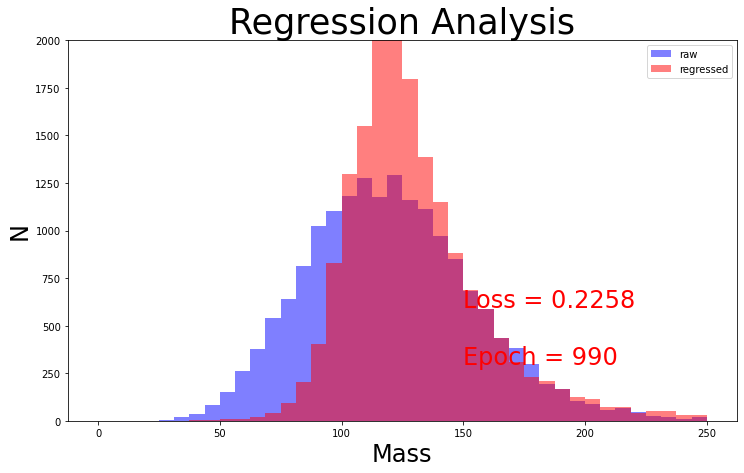

In [191]:
#images=train(x,y,net,loss_func,optimizer,1000)
#imageio.mimsave('./reg2_long.gif', images, fps=12)
images=train(x,y,net,loss_func,optimizer,100)
imageio.mimsave('./reg2_long.gif', images, fps=12)

### Challenge Question

Repeat the above regression, but now make the true mass `genhmass` as the target variable, what happens to the regression? Why will this not work? 

## 15.6  The full Mass regression

Ok, now that we have a setup that seems to be working the final challenge is to use all the possible information that we have in our event to do the best reconstruction we possibly can. In this case, what we will do is use as many different variables as we possibly can to predict the neutrino position. 

The way we are going to do this, is dig into the dataset a little bit. A $\tau$ lepton is reconstructed in the same way a jet is reconstructed at the LHC. We first look for a clump of particles that have a large amount of energy in a cone. In this case, we also look for, what we called an isolated clump. Namely, we see a few particles in the cone that have very large momentum and, when we remove these particles, the rest of the momentum in the cone is small (typically less that 10 percent the total momentum). This final colleciton of particles, gives us a $\tau$ lepton. 

Interestingly the decay components of the $\tau$ lepton in the cone can tell us information about the energy of the neutrino. The reason comes from the decay of the $\tau$ lepton. A $\tau$ has a fixed mass at 1.75 GeV. As a consequence, the invariant mass of the all of the particles within a cone should sum up to the $\tau$ lepton. In reality, we can't get this perfectly because our measurements are not perfect. However, we know that that

\begin{eqnarray}
\left(\sum_{i} \vec{p_{i}}\right)^2 & \approx & m^{2}_{\tau} \\
\left(\sum_{i\neq{\rm neutrino}} \vec{p_{i}} + \sum_{i={\rm neutrino}} \vec{p_{i}} \right)^2 & \approx & m^{2}_{\tau} \\
\end{eqnarray}
or in other words, the neutrino positions and directions are constrained by the other particles in the $\tau$ decay. We don't need to expand this equation and solve it, we just need to know there is a correlation to know that we use the $\tau$ decay components to solve for the neutrino position.  

This all means that we can build a neural network with the particles as input to predict the neutrino positions. Let's go ahead and look at a few taus, and then we build our network and train it.  

In [44]:
#Lets compute the mass on the fly
def makedataset(iMask,iPart="part1"):
    varlist=[iPart+"pt1",iPart+"eta1",iPart+"phi1",iPart+"id1",iPart+"pt2",iPart+"eta2",iPart+"phi2",iPart+"id2",iPart+"pt3",iPart+"eta3",iPart+"phi3",iPart+"id3",iPart+"pt4",iPart+"eta4",iPart+"phi4",iPart+"id4",iPart+"pt5",iPart+"eta5",iPart+"phi5",iPart+"id5"]
    arr=0
    idx=0
    for x in varlist:
        pArr=reg[x].array(library="np")[iMask]
        if idx == 0: 
            arr = pArr
            idx = idx + 1
        else:
            arr=np.vstack((arr,pArr))
    arr = arr.T
    return arr

mask1=(reg["genpt1"].array(library="np") > 0)
mask2=(reg["recopt1"].array(library="np") > 0)
mask3=(reg["genpt2"].array(library="np") > 0)
mask4=(reg["recopt2"].array(library="np") > 0)
mask = np.logical_and.reduce([mask1,mask2,mask3,mask4])
x=torch.from_numpy(makedataset(mask))
yb=torch.from_numpy(reg["recopt1"].array(library="np")[mask].reshape(len(reg["recopt1"].array(library="np")[mask]),1))
y=torch.from_numpy(reg["genpt1"].array(library="np")[mask].reshape(len(reg["genpt1"].array(library="np")[mask]),1))
ratio=torch.div(y,yb)
y=ratio
x,y = Variable(x),Variable(y)
torch_dataset = Data.TensorDataset(x, y)
#print(x)

To get a feel for how these corrections work, we can visualize a few events by making some evnet plots to look at the top 5 particles in position space. 

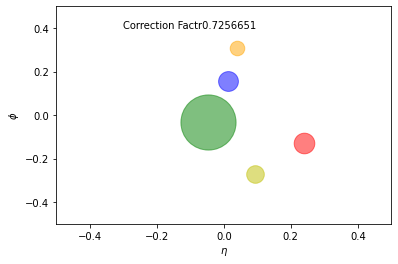

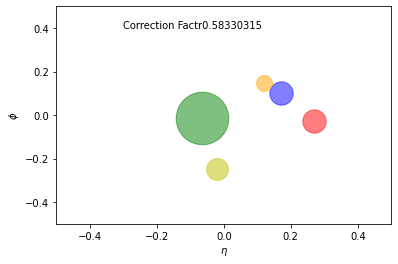

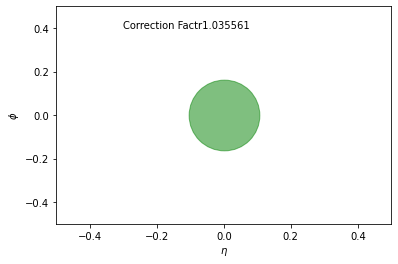

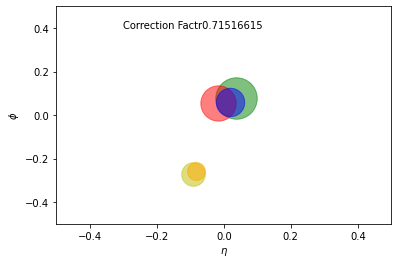

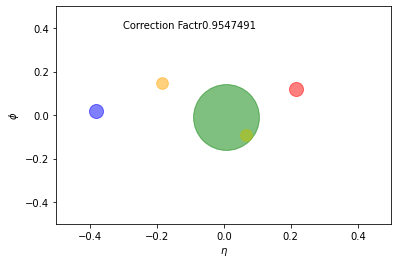

In [38]:
ds=makedataset(mask)
colors = ['g','r','b','y','orange']
for i0 in range(5):
    for ipart in range(5):
        plt.scatter(ds[i0,4*ipart+1], ds[i0,4*ipart+2], s=ds[i0,4*ipart]*5000/yb[i0], c=colors[ipart], alpha=0.5)
    plt.xlim(-0.5,0.5)
    plt.ylim(-0.5,0.5)
    plt.xlabel("$\eta$")
    plt.ylabel("$\phi$")
    plt.text(-0.3,0.4,"Correction Factr"+str(ratio[i0].numpy()[0]))
    plt.show()

Broadly speaking, what we observe is that events that are spread out tend to have larger corrections that events that are not. This means we can use this shape to actually predict the correction. There is some more subtlety coming from the fact that $\tau$ leptons decay into different particle types. That will allow us to understand the type of decay that occurred. For example, $\tau$ lepton decays that have a lot of photons, will have a different energy distribution that $\tau$ leptons that don't have any photons. 

Alright, lets go ahead and train our network. 

In [51]:
#now lets see if we can improve this with something more complicated
net = torch.nn.Sequential(
        torch.nn.Linear(20, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 50),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(50, 1),
    )
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

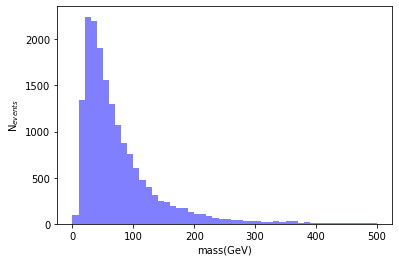

In [46]:
p1=torch.from_numpy(makedataset(mask,"part1"))
p2=torch.from_numpy(makedataset(mask,"part2"))

def masscomputeNN(iC1,iC2,iVec1,iVec2):
    corr1 = iC1*iVec1[0]
    corr2 = iC2*iVec2[0]
    tau_1 = Momentum4.m_eta_phi_pt(iVec1[3], iVec1[1], iVec1[2], corr1)
    tau_2 = Momentum4.m_eta_phi_pt(iVec2[3], iVec2[1], iVec2[2], corr2)
    return (tau_1+tau_2).m

#now lets compute the corrected mass on the data set
def hmass(masscomputeNN):
    corr1=net(p1)
    corr2=net(p2)
    varlist=["recopt1","recoeta1","recophi1","recomass1","recopt2","recoeta2","recophi2","recomass2"]
    arr=np.vstack((corr1.data.numpy().T,corr2.data.numpy().T))
    for x in varlist:
        pArr=reg[x].array(library="np")[mask]
        arr=np.vstack((arr,pArr))
    arr = arr.T
    massc = lambda iarr: masscomputeNN(iarr[0],iarr[1],iarr[2:6],iarr[6:10]) 
    hmasses = np.array([massc(p) for p in arr])
    return hmasses

#now update to add history
history_lr = {'loss':[], 'val_loss':[]}
def train(x,y,net,loss_func,opt,nepochs):
    images = []
    fig, ax = plt.subplots(figsize=(12,7))
    for epoch in range(nepochs):
        if epoch % 50 == 0: 
            print("epoch:",epoch)
        prediction = net(x)
        loss = loss_func(prediction, y) 
        opt.zero_grad()
        loss.backward() 
        optimizer.step()
        with torch.no_grad():#disable updating gradient
            print('[%d] loss: %.4f ' % (epoch + 1, loss ))
            history_lr['loss'].append(loss)
        if epoch % 5 == 0:
            makePlot(x,y,prediction,ax,fig,images,epoch,loss)
    return images

rawmass=hmass(masscomputeNN)
plt.hist(rawmass,bins=50,range=(0,500),color='blue',alpha=0.5,label="Adding the NN")
plt.xlabel("mass(GeV)")
plt.ylabel("N$_{events}$")
plt.show()

epoch: 0
[1] loss: 23.2972 
[2] loss: 8086.8101 
[3] loss: 54.9690 
[4] loss: 194.5180 
[5] loss: 87.5467 
[6] loss: 11.4870 
[7] loss: 0.7727 
[8] loss: 6.0202 
[9] loss: 4.5186 
[10] loss: 1.1035 
[11] loss: 0.2752 
[12] loss: 0.4711 
[13] loss: 0.9097 
[14] loss: 1.2054 
[15] loss: 1.2925 
[16] loss: 1.2268 
[17] loss: 1.0427 
[18] loss: 0.7893 
[19] loss: 0.5430 
[20] loss: 0.3508 
[21] loss: 0.2630 
[22] loss: 0.3133 
[23] loss: 0.4280 
[24] loss: 0.4822 
[25] loss: 0.4696 
[26] loss: 0.4107 
[27] loss: 0.3283 
[28] loss: 0.2631 
[29] loss: 0.2403 
[30] loss: 0.2567 
[31] loss: 0.2923 
[32] loss: 0.3251 
[33] loss: 0.3403 
[34] loss: 0.3329 
[35] loss: 0.3068 
[36] loss: 0.2732 
[37] loss: 0.2456 
[38] loss: 0.2350 
[39] loss: 0.2434 
[40] loss: 0.2622 
[41] loss: 0.2767 
[42] loss: 0.2768 
[43] loss: 0.2631 
[44] loss: 0.2454 
[45] loss: 0.2340 
[46] loss: 0.2331 
[47] loss: 0.2399 
[48] loss: 0.2481 
[49] loss: 0.2510 
[50] loss: 0.2453 
epoch: 50
[51] loss: 0.2345 
[52] loss: 0

[412] loss: 0.1526 
[413] loss: 0.1526 
[414] loss: 0.1525 
[415] loss: 0.1525 
[416] loss: 0.1524 
[417] loss: 0.1524 
[418] loss: 0.1523 
[419] loss: 0.1523 
[420] loss: 0.1522 
[421] loss: 0.1521 
[422] loss: 0.1521 
[423] loss: 0.1520 
[424] loss: 0.1520 
[425] loss: 0.1519 
[426] loss: 0.1519 
[427] loss: 0.1518 
[428] loss: 0.1518 
[429] loss: 0.1517 
[430] loss: 0.1517 
[431] loss: 0.1516 
[432] loss: 0.1516 
[433] loss: 0.1515 
[434] loss: 0.1515 
[435] loss: 0.1514 
[436] loss: 0.1514 
[437] loss: 0.1513 
[438] loss: 0.1513 
[439] loss: 0.1512 
[440] loss: 0.1512 
[441] loss: 0.1511 
[442] loss: 0.1511 
[443] loss: 0.1510 
[444] loss: 0.1510 
[445] loss: 0.1509 
[446] loss: 0.1509 
[447] loss: 0.1508 
[448] loss: 0.1508 
[449] loss: 0.1507 
[450] loss: 0.1507 
epoch: 450
[451] loss: 0.1506 
[452] loss: 0.1506 
[453] loss: 0.1505 
[454] loss: 0.1505 
[455] loss: 0.1504 
[456] loss: 0.1504 
[457] loss: 0.1504 
[458] loss: 0.1503 
[459] loss: 0.1503 
[460] loss: 0.1502 
[461] los

[820] loss: 0.1384 
[821] loss: 0.1381 
[822] loss: 0.1381 
[823] loss: 0.1379 
[824] loss: 0.1378 
[825] loss: 0.1380 
[826] loss: 0.1379 
[827] loss: 0.1379 
[828] loss: 0.1379 
[829] loss: 0.1376 
[830] loss: 0.1378 
[831] loss: 0.1377 
[832] loss: 0.1376 
[833] loss: 0.1378 
[834] loss: 0.1375 
[835] loss: 0.1376 
[836] loss: 0.1375 
[837] loss: 0.1375 
[838] loss: 0.1377 
[839] loss: 0.1375 
[840] loss: 0.1374 
[841] loss: 0.1375 
[842] loss: 0.1374 
[843] loss: 0.1373 
[844] loss: 0.1374 
[845] loss: 0.1373 
[846] loss: 0.1373 
[847] loss: 0.1374 
[848] loss: 0.1373 
[849] loss: 0.1372 
[850] loss: 0.1372 
epoch: 850
[851] loss: 0.1372 
[852] loss: 0.1372 
[853] loss: 0.1372 
[854] loss: 0.1372 
[855] loss: 0.1371 
[856] loss: 0.1371 
[857] loss: 0.1371 
[858] loss: 0.1370 
[859] loss: 0.1371 
[860] loss: 0.1371 
[861] loss: 0.1369 
[862] loss: 0.1370 
[863] loss: 0.1371 
[864] loss: 0.1369 
[865] loss: 0.1371 
[866] loss: 0.1370 
[867] loss: 0.1369 
[868] loss: 0.1371 
[869] los

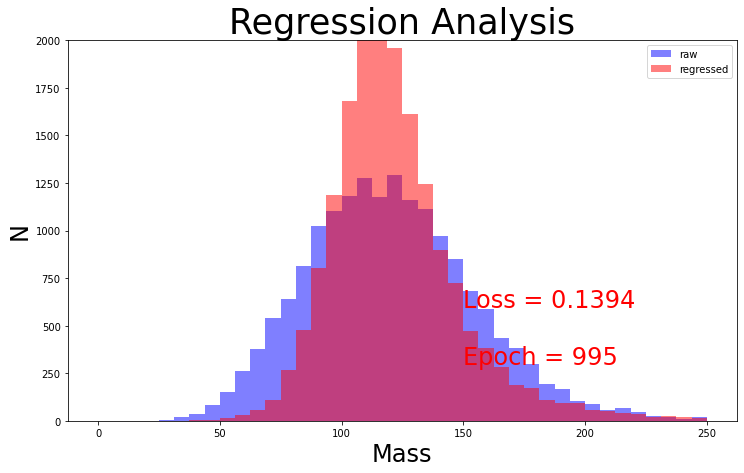

In [52]:
images=train(x,y,net,loss_func,optimizer,1000)
imageio.mimsave('./reg2.gif', images, fps=12)
#images=train(x,y,net,loss_func,optimizer,1000)
#imageio.mimsave('./reg_long.gif', images, fps=12)

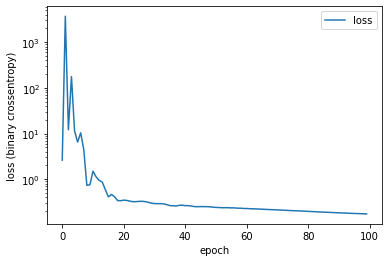

In [48]:
plt.semilogy(history_lr['loss'], label='loss')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss (binary crossentropy)')
plt.show()

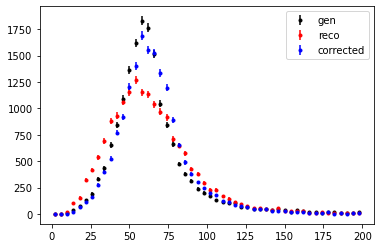

In [316]:
def plotcorr(iVar,iNN,iMin,iMax,iColor,iLabel,iCorr=True): 
    corr1=net(p1)
    data=reg[iVar].array(library="np")[mask]
    if iCorr:
        data=data*corr1.data.numpy().T
    counts, binEdges = np.histogram(data,bins=50,range=(iMin,iMax),density=False)
    binCenters = (binEdges[1:]+binEdges[:-1])*.5
    err = np.sqrt(counts)
    plt.errorbar(binCenters, counts, yerr=err,fmt="o",c=iColor, ms=3,label=iLabel)
    
plotcorr("genpt1" ,net,0,200,"black","gen",False)
plotcorr("recopt1",net,0,200,"red","reco",False)
plotcorr("recopt1",net,0,200,"blue","corrected")
plt.legend()
plt.show()


### 15.7 NN Architecture

Now one last thing that we can cnosider is to use a different type of architecture for the neutral network. This is where deep learning has become very valuable over the last 10 years. By making it such that entworks take only a subset of inputs at a time, we can effectively organize the training of the data, and guide the deep learning arhitecture to a better overall minimimu. 

For the $\tau$ regression, the ideal tool for this is a recurrent neural network or an [RNN](https://en.wikipedia.org/wiki/Recurrent_neural_network). These networks are designed to take in data, piece by piece to build up a prediction. They are often used on time series datasets, like the LIGO dataset, to process data and infer the likelihood of an event or to apply a correction. Perhaps, their most common use has been in language translation to translate word by word, or phrase by phrase. 

In recent times, high energy physicsists have taken to using RNNs to proces data by feeding the RNN individual particles at a time. The nice thing is that since this takes in a series of particles, we could, in principle, give it a variable number of particles. 

In this example, we will use a long-short term memory (LSTM) network. Here is the pytorch for how its defined. 

In [53]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size, 20)
        self.fc2 = nn.Linear(20, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc1(h_out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

input_size = 4
hidden_size = 128
num_layers = 1
num_classes = 1
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.01)
lstm.train()

LSTM(
  (lstm): LSTM(4, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)

Now to process the data, we need to format it slightly differently. 

In [54]:
def makedatasetrnn(iMask,iPart="part1"):
    arr=makedataset(iMask,iPart)
    return arr.reshape(len(arr),5,4)

x=torch.from_numpy(makedatasetrnn(mask))

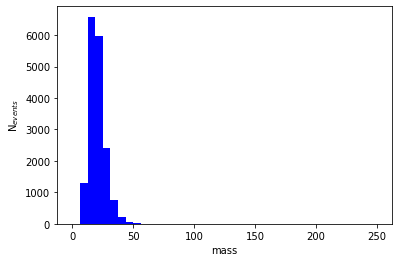

In [55]:
p1=torch.from_numpy(makedatasetrnn(mask,"part1"))
p2=torch.from_numpy(makedatasetrnn(mask,"part2"))

#now lets compute the corrected mass on the data set
def hmass(masscomputeNN):
    mask=(reg["recohmass"].array(library="np") > 0)
    corr1=lstm(p1)
    corr2=lstm(p2)
    varlist=["recopt1","recoeta1","recophi1","recomass1","recopt2","recoeta2","recophi2","recomass2"]
    arr=np.vstack((corr1.data.numpy().T,corr2.data.numpy().T))
    for x in varlist:
        pArr=reg[x].array(library="np")[mask]
        arr=np.vstack((arr,pArr))
    arr = arr.T
    massc = lambda iarr: masscomputeNN(iarr[0],iarr[1],iarr[2:6],iarr[6:10]) 
    hmasses = np.array([massc(p) for p in arr])
    return hmasses

outmass=hmass(masscomputeNN)
plt.hist(outmass,bins=40,range=(0,250),color='blue')
plt.xlabel("mass")
plt.ylabel("N$_{events}$")
plt.show()

epoch: 0
[1] loss: 1.3054 
[2] loss: 1.0019 
[3] loss: 0.5514 
[4] loss: 0.3102 
[5] loss: 0.4576 
[6] loss: 0.3259 
[7] loss: 0.2527 
[8] loss: 0.2659 
[9] loss: 0.2876 
[10] loss: 0.2832 
[11] loss: 0.2604 
[12] loss: 0.2397 
[13] loss: 0.2372 
[14] loss: 0.2500 
[15] loss: 0.2547 
[16] loss: 0.2422 
[17] loss: 0.2318 
[18] loss: 0.2280 
[19] loss: 0.2296 
[20] loss: 0.2323 
[21] loss: 0.2327 
[22] loss: 0.2304 
[23] loss: 0.2265 
[24] loss: 0.2245 
[25] loss: 0.2218 
[26] loss: 0.2220 
[27] loss: 0.2215 
[28] loss: 0.2219 
[29] loss: 0.2203 
[30] loss: 0.2184 
[31] loss: 0.2149 
[32] loss: 0.2142 
[33] loss: 0.2122 
[34] loss: 0.2104 
[35] loss: 0.2093 
[36] loss: 0.2063 
[37] loss: 0.2047 
[38] loss: 0.2019 
[39] loss: 0.1988 
[40] loss: 0.1971 
[41] loss: 0.1998 
[42] loss: 0.2043 
[43] loss: 0.1879 
[44] loss: 0.1998 
[45] loss: 0.1878 
[46] loss: 0.1856 
[47] loss: 0.1835 
[48] loss: 0.1796 
[49] loss: 0.1803 
[50] loss: 0.1710 
epoch: 50
[51] loss: 0.1737 
[52] loss: 0.1824 
[5

[412] loss: 0.1318 
[413] loss: 0.1321 
[414] loss: 0.1302 
[415] loss: 0.1294 
[416] loss: 0.1298 
[417] loss: 0.1309 
[418] loss: 0.1334 
[419] loss: 0.1321 
[420] loss: 0.1320 
[421] loss: 0.1291 
[422] loss: 0.1288 
[423] loss: 0.1308 
[424] loss: 0.1322 
[425] loss: 0.1368 
[426] loss: 0.1302 
[427] loss: 0.1290 
[428] loss: 0.1336 
[429] loss: 0.1325 
[430] loss: 0.1322 
[431] loss: 0.1288 
[432] loss: 0.1301 
[433] loss: 0.1342 
[434] loss: 0.1294 
[435] loss: 0.1273 
[436] loss: 0.1286 
[437] loss: 0.1289 
[438] loss: 0.1278 
[439] loss: 0.1270 
[440] loss: 0.1272 
[441] loss: 0.1282 
[442] loss: 0.1280 
[443] loss: 0.1273 
[444] loss: 0.1262 
[445] loss: 0.1262 
[446] loss: 0.1267 
[447] loss: 0.1274 
[448] loss: 0.1288 
[449] loss: 0.1273 
[450] loss: 0.1267 
epoch: 450
[451] loss: 0.1257 
[452] loss: 0.1252 
[453] loss: 0.1249 
[454] loss: 0.1247 
[455] loss: 0.1247 
[456] loss: 0.1250 
[457] loss: 0.1262 
[458] loss: 0.1279 
[459] loss: 0.1352 
[460] loss: 0.1288 
[461] los

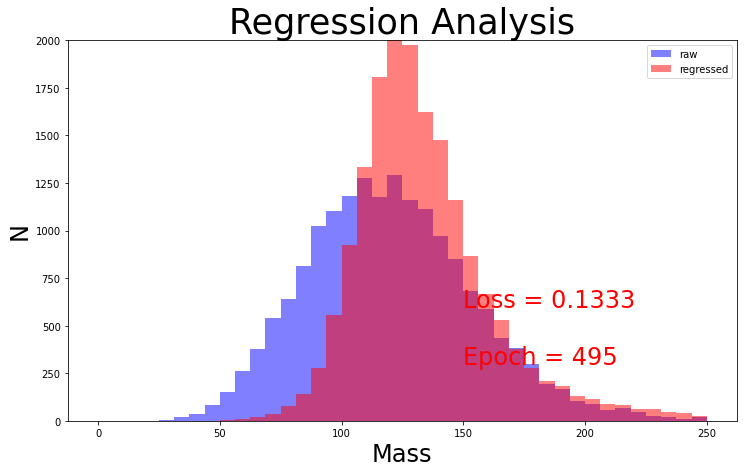

In [56]:
images=train(x,y,lstm,criterion,optimizer,500)
imageio.mimsave('./reg_lstm.gif', images, fps=12)
#images=train(x,y,lstm,criterion,optimizer,1000)
#imageio.mimsave('./reg_lstm_long.gif', images, fps=12)

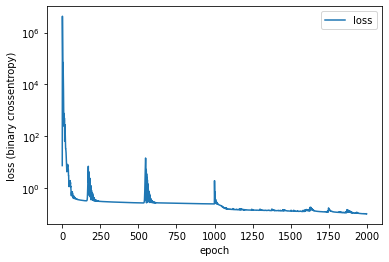

In [311]:
plt.semilogy(history_lr['loss'], label='loss')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss (binary crossentropy)')
plt.show()

In [318]:
plotcorr("genpt1" ,lstm,0,200,"black","gen",False)
plotcorr("recopt1",lstm,0,200,"red","reco",False)
plotcorr("recopt1",lstm,0,200,"blue","corrected")
plt.legend()
plt.show()

TypeError: plotcorr() takes 5 positional arguments but 7 were given

76.08147269220194
90.6497064526363


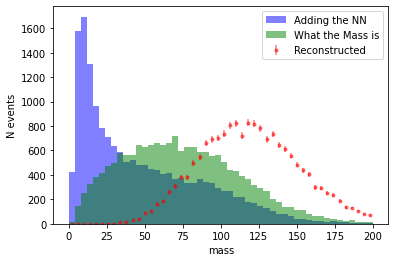

In [352]:
randscale=np.random.uniform(0, 1,len(y))

#Lets compute the mass on the fly
def makedataset(iMask,iPart="part1"):
    varlist=[iPart+"pt1",iPart+"eta1",iPart+"phi1",iPart+"id1",iPart+"pt2",iPart+"eta2",iPart+"phi2",iPart+"id2",iPart+"pt3",iPart+"eta3",iPart+"phi3",iPart+"id3",iPart+"pt4",iPart+"eta4",iPart+"phi4",iPart+"id4",iPart+"pt5",iPart+"eta5",iPart+"phi5",iPart+"id5"]
    arr=0
    idx=0
    for x in varlist:
        pArr=reg[x].array(library="np")[iMask]
        if "pt" in x:
            pArr=pArr*randscale
        if idx == 0: 
            arr = pArr
            idx = idx + 1
        else:
            arr=np.vstack((arr,pArr))
    arr = arr.T
    return arr

p1p=torch.from_numpy(makedatasetrnn(mask,"part1")).float()
p2p=torch.from_numpy(makedatasetrnn(mask,"part2")).float()


#now lets compute the corrected mass on the data set
def hmass(masscomputeNN,iCorr=True):
    mask=(reg["recohmass"].array(library="np") > 0)
    corr1=lstm(p1p)
    corr2=lstm(p2p)
    varlist=["recopt1","recoeta1","recophi1","recomass1","recopt2","recoeta2","recophi2","recomass2"]
    arr=np.vstack((corr1.data.numpy().T,corr2.data.numpy().T))
    for x in varlist:
        pArr=reg[x].array(library="np")[mask]
        if "pt" in x:
            arr=arr*randscale
        arr=np.vstack((arr,pArr))
    arr = arr.T
    if not iCorr:
        arr[:,0]/=arr[:,0]
        arr[:,1]/=arr[:,1]
    massc = lambda iarr: masscomputeNN(iarr[0],iarr[1],iarr[2:6],iarr[6:10]) 
    hmasses = np.array([massc(p) for p in arr])
    return hmasses


rawmass=hmass(masscomputeNN,True)
print(rawmass[-1])
plt.hist(rawmass,bins=50,range=(0,200),color='blue',alpha=0.5,label="Adding the NN")

rawmass=hmass(masscomputeNN,False)
print(rawmass[-1])
plt.hist(rawmass,bins=50,range=(0,200),color='green',alpha=0.5,label="What the Mass is")

#plot("hmass",0,200,"black","True Higgs Mass")
recohmassX,recohmassY,recohmassYErr=plot("recohmass",0,200,"red","Reconstructed")
plt.legend()
plt.show()